# COMP3610 - Big Data - Project
Done by: Team 3 & A 1/2 Men

In [256]:
import re
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns

from os import path, chdir

from matplotlib import pyplot as plt
from google.colab import drive

from nltk import download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.metrics import Accuracy, Precision
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

download(['wordnet', 'stopwords', 'punkt'])
drive.mount('/content/drive')
chdir("/content/drive/MyDrive/COMP3610 Big Data Colab Project")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Spotify Data Pre-processing

In [257]:
spotify_data = pd.read_csv("spotify_master.csv")

In [258]:
spotify_data.describe()

,energy,key,tempo
count,1.204025e+06,1.204025e+06,1.204025e+06
mean,5.095363e-01,5.194151e+00,1.176344e+02
std,2.946839e-01,3.536731e+00,3.093705e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.520000e-01,2.000000e+00,9.405400e+01
50%,5.240000e-01,5.000000e+00,1.167260e+02
75%,7.660000e-01,8.000000e+00,1.370460e+02
max,1.000000e+00,1.100000e+01,2.489340e+02


In [259]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204025 entries, 0 to 1204024
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   id      1204025 non-null  object 
 1   name    1204022 non-null  object 
 2   energy  1204025 non-null  float64
 3   key     1204025 non-null  int64  
 4   tempo   1204025 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 45.9+ MB


Dropping features from the data `instrumentalness`, `liveness`, `time_signature`, `year`, `release_date`, `album_id`, `album`, `artist_ids`, `track_number`, `disc_number`, `explicit`, `danceability`, `acousticness`, `duration_ms`, `artists`, `mode`, `loudness`, `speechiness` and `valence`.

In summary, the most helpful features kept are: `id`, `name`, `energy` `key` and `tempo`

### Get Timbre values from the Spotify Web API

In [260]:
timbre_file = "spotify_tracks_timbre.csv"
timbre_data = pd.read_csv(timbre_file)

In [261]:
# Drop all the HTTP status values
timbre_data = timbre_data.drop(['status'], axis=1)

In [262]:
# Sum the timbre vector
def sum_timbre_vector(timbre):
    timbre = re.findall(r"[-+]?\d*\.\d+|\d+", timbre)
    timbre = [float(i) for i in timbre]
    return sum(timbre)

# Apply function on timbre column in df2
timbre_data['timbre'] = timbre_data['timbre'].apply(sum_timbre_vector)

In [263]:
# Merge the two dataframes
spotify_data = pd.merge(spotify_data, timbre_data, on="id")
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27040 entries, 0 to 27039
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      27040 non-null  object 
 1   name    27040 non-null  object 
 2   energy  27040 non-null  float64
 3   key     27040 non-null  int64  
 4   tempo   27040 non-null  float64
 5   timbre  27040 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.2+ MB


### Normalise Song Features
Note the following:
- The maximum possible key value is $11$ according to the [Spotify Web API Track Audio Features Documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-features)
- The maximum possible timbre is $12$ (summation of values in 12-vector that range from $0 - 1$) according to the [Spotify Web API Track Audio Analysis Documentation](https://developer.spotify.com/documentation/web-api/reference/get-audio-analysis)
- The energy values are already in a normalised range of $0 - 1$
- The tempo column was chosen not to be normalised since we have no official documentation nor research that can provided a maximum tempo value. In fact, multiple sources indicate that the tempo of music is _indeed_ unbounded

In [264]:
def normalise_timbre(timbre): return round((timbre / 12), 3)
def normalise_energy(energy): return round(energy, 3)
def normalise_key(key): return 0 if key <= 0 else round((key / 11), 3)

spotify_data['timbre'] = spotify_data['timbre'].apply(normalise_timbre)
spotify_data['energy'] = spotify_data['energy'].apply(normalise_energy)
spotify_data['key']    = spotify_data['key'].apply(normalise_key)
MAX_TEMPO = spotify_data['tempo'].max()

In [265]:
spotify_data = spotify_data.drop(columns=['id', 'name'])

In [266]:
spotify_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27040 entries, 0 to 27039
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   energy  27040 non-null  float64
 1   key     27040 non-null  float64
 2   tempo   27040 non-null  float64
 3   timbre  27040 non-null  float64
dtypes: float64(4)
memory usage: 845.1 KB


In [267]:
spotify_data.describe()

,energy,key,tempo,timbre
count,27040.000000,27040.000000,27040.000000,27040.000000
mean,0.505914,0.469712,117.574622,0.498946
std,0.294309,0.321380,30.892820,0.229991
min,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.182000,94.065250,0.314000
50%,0.518000,0.455000,116.481000,0.479000
75%,0.761000,0.727000,136.854000,0.658000
max,1.000000,1.000000,222.859000,1.000000


### Initial Visualisations of Various Features vs. Tempo

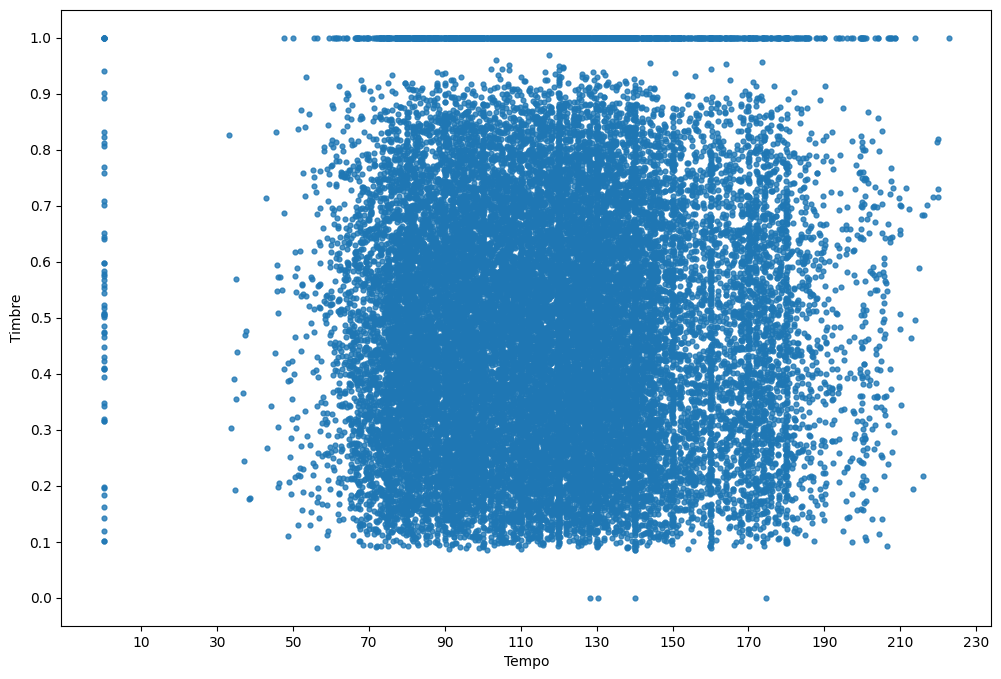

In [268]:
plt.figure(figsize=(12, 8))
plt.scatter(spotify_data['tempo'], spotify_data['timbre'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(10, 240, 20))
plt.ylabel('Timbre')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

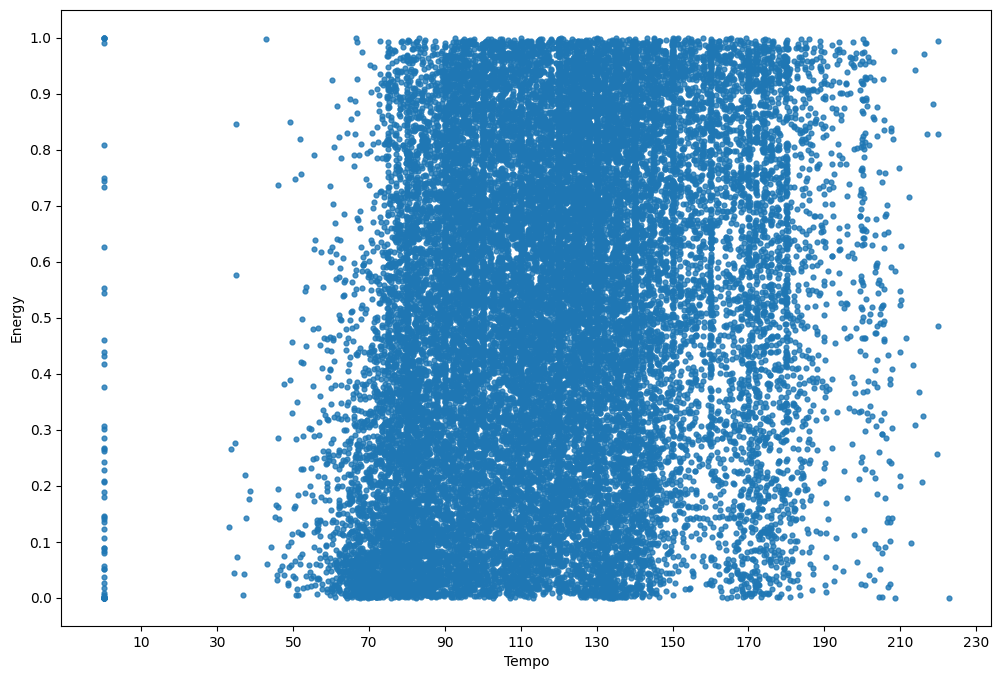

In [269]:
plt.figure(figsize=(12, 8))
plt.scatter(spotify_data['tempo'], spotify_data['energy'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(10, 240, 20))
plt.ylabel('Energy')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

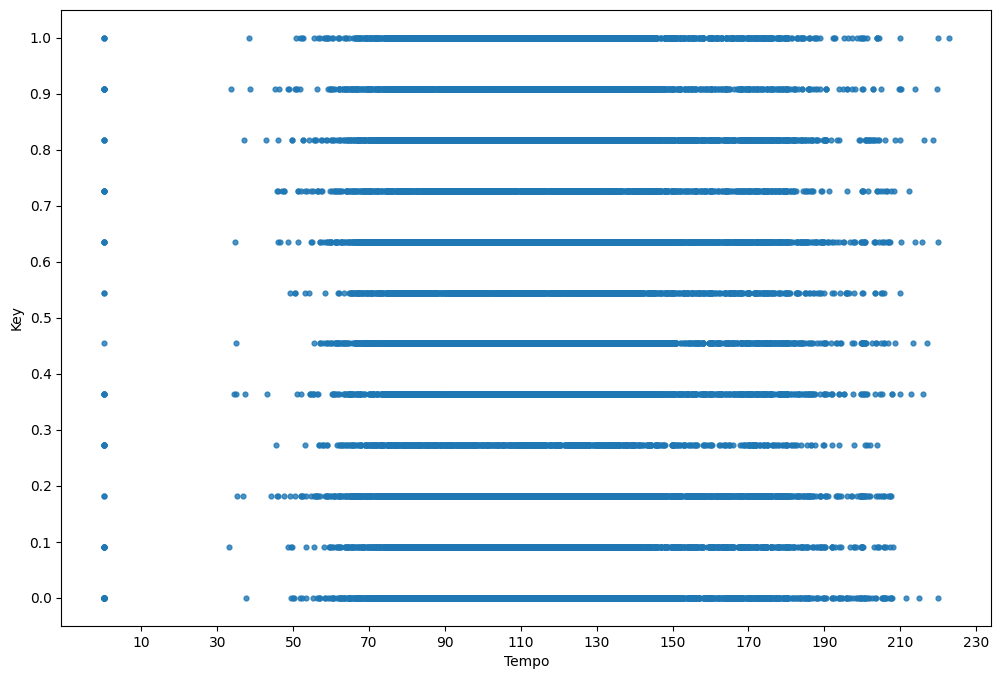

In [270]:
plt.figure(figsize=(12, 8))
plt.scatter(spotify_data['tempo'], spotify_data['key'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(10, 240, 20))
plt.ylabel('Key')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

### Justifying Outlier Removal in Tempo Column
We can see that there are consistent outliers in the dataset's tempo values: values less than 10 can be safely eradicated since there exists a clear disparity between tempo values less than 10 and those greater than 10

In [271]:
tempo_outliers = np.where(spotify_data['tempo'] <= 10)
spotify_data = spotify_data.drop(tempo_outliers[0])
spotify_data = spotify_data.reset_index(drop=True)

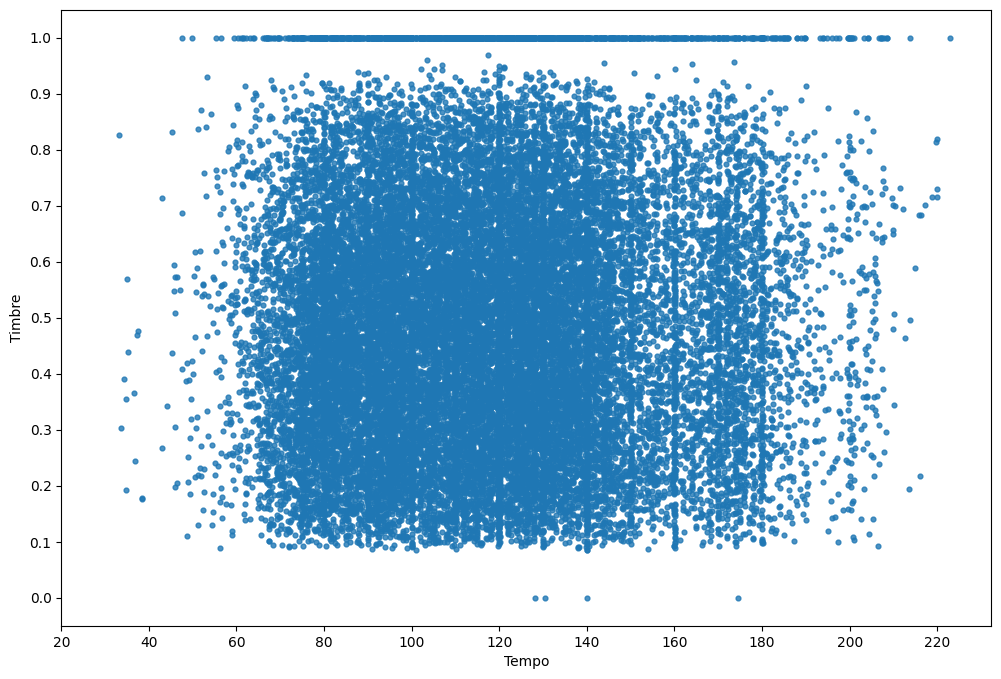

In [272]:
plt.figure(figsize=(12, 8))
plt.scatter(spotify_data['tempo'], spotify_data['timbre'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(20, 240, 20))
plt.ylabel('Timbre')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

### Justifying Outlier Removal in Timbre Column
We can observe that there seem to be a value of 1 for timbre vectors that are set to the default state (no data available). As such, these datapoints will be dropped.

In addition, the timbre values that are less than 0.05 seem to add no relative value to the main data cluster. Resultantly, they will also be removed

In [273]:
timbre_outliers = np.where((spotify_data['timbre'] <= 0.05) | (spotify_data['timbre'] == 1.0))
spotify_data = spotify_data.drop(timbre_outliers[0])
spotify_data = spotify_data.reset_index(drop=True)

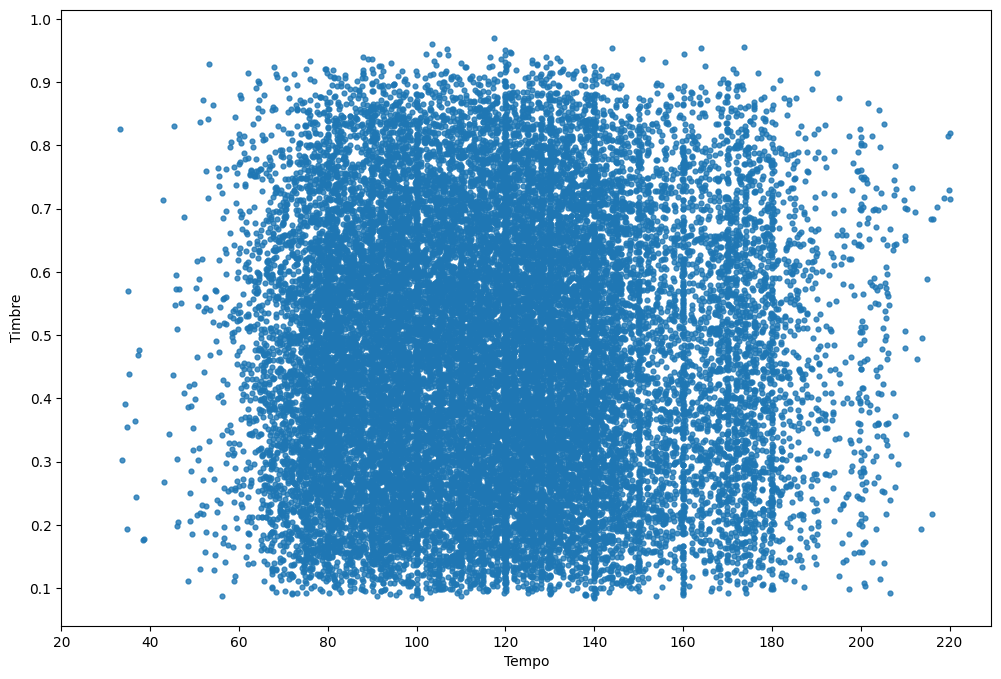

In [274]:
plt.figure(figsize=(12, 8))
plt.scatter(spotify_data['tempo'], spotify_data['timbre'], s=12, alpha=.8)
plt.xlabel('Tempo')
plt.xticks(np.arange(20, 240, 20))
plt.ylabel('Timbre')
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.show()

### Visualising Tempo vs Key

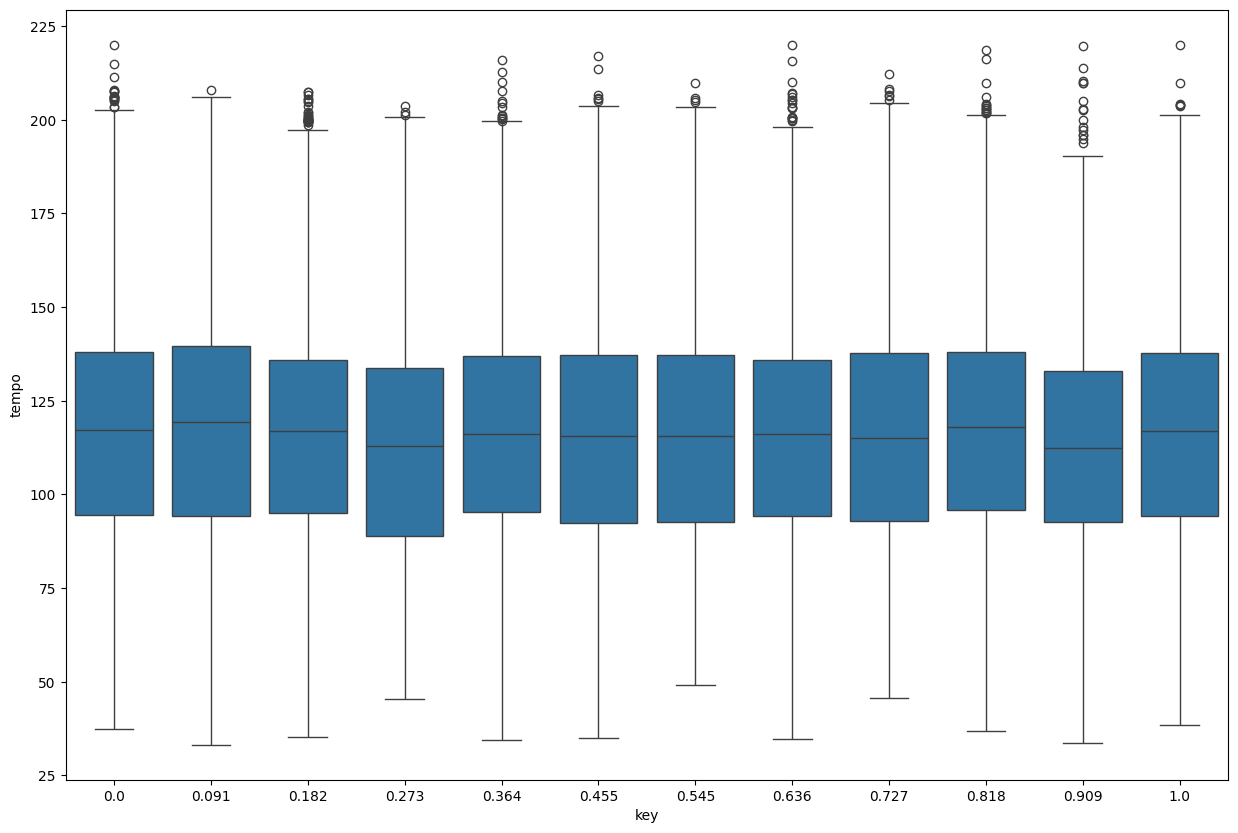

In [275]:
plt.figure(figsize=(15, 10))
sns.boxplot(x=spotify_data['key'], y=spotify_data['tempo'])
plt.xticks(np.arange(0, 12, 1))
plt.show()

## Music Mood Classification

### Extracting Ideal Cases in Spotify Dataset
According to [research](https://sites.tufts.edu/eeseniordesignhandbook/2015/music-mood-classification/), the following ranges were exprapolated from mean values of the features that indicate a particular mood. We have decided to fine tune these ranges such that they are able to detect and classify a substantial number of songs per mood.

In [276]:
features = {
    "energy" : 0,
    "timbre" : 1,
    "key"    : 2,
    "tempo"  : 3
}

moods = {
  "Happy":       [(0.4, 0.6), (0.3, 0.5), (0.7, 1.0), (175, MAX_TEMPO)],
  "Exuberant":   [(0.6, 0.8), (0.3, 0.5), (0.6, 0.7), (160, 175)],
  "Energetic":   [(0.8, 1.0), (0.3, 0.5), (0.4, 0.6), (160, 175)],
  "Frantic":     [(0.6, 0.8), (0.6, 1.0), (0.2, 0.4), (175, MAX_TEMPO)],
  "Sad":         [(0.4, 0.6), (0.0, 0.2), (0.0, 0.2), (75,  100)],
  "Depression":  [(0.2, 0.4), (0.2, 0.3), (0.2, 0.4), (75,  100)],
  "Calm":        [(0.0, 0.2), (0.0, 0.2), (0.4, 0.6), (0,    75)],
  "Contentment": [(0.2, 0.4), (0.2, 0.3), (0.6, 0.7), (75,  100)]
}

Using the above ranges to pull out 'ideal' cases

In [277]:
ideal_cases = {
  "Happy" : [],
  "Exuberant" : [],
  "Energetic" : [],
  "Frantic" : [],
  "Sad" : [],
  "Depression" : [],
  "Calm" : [],
  "Contentment" : []
}

def check_range(value: float, range): return range[0] <= value < range[1]

# Pull ideal cases from data file
for idx, row in enumerate(spotify_data.index):
    for mood in ideal_cases.keys():
        if check_range(spotify_data['energy'][idx], moods[mood][features['energy']]) and \
           check_range(spotify_data['timbre'][idx], moods[mood][features['timbre']]) and \
           check_range(spotify_data['key'][idx],    moods[mood][features['key']])    and \
           check_range(spotify_data['tempo'][idx],  moods[mood][features['tempo']]):
            ideal_cases[mood].append(spotify_data.iloc[idx])

# Generate new sample points
max_points = 60
for mood in ideal_cases.keys():
    print(f"Added {max_points - len(ideal_cases[mood])} to {mood} category")
    for x in range(0, max_points - len(ideal_cases[mood])):
        rand_energy = round(random.uniform(moods[mood][features['energy']][0], moods[mood][features['energy']][1]), 3)
        rand_timbre = round(random.uniform(moods[mood][features['timbre']][0], moods[mood][features['timbre']][1]), 3)
        rand_key    = round(random.uniform(moods[mood][features['key']][0],    moods[mood][features['key']][1]), 3)
        rand_tempo  = np.random.randint(moods[mood][features['tempo']][0],  moods[mood][features['tempo']][1])
        df = pd.DataFrame(columns=spotify_data.columns, data=[[rand_energy, rand_key, rand_tempo, rand_timbre]])
        # print(pd.DataFrame(columns=spotify_data.columns, data=[[rand_energy, rand_timbre, rand_key, rand_tempo]]))
        ideal_cases[mood].append(df.iloc[0])


for key in ideal_cases.keys():
   print(key, "=>", len(ideal_cases[key]))

Added 43 to Happy category
Added 49 to Exuberant category
Added 37 to Energetic category
Added 53 to Frantic category
Added 9 to Sad category
Added 33 to Depression category
Added 52 to Calm category
Added 26 to Contentment category
Happy => 60
Exuberant => 60
Energetic => 60
Frantic => 60
Sad => 60
Depression => 60
Calm => 60
Contentment => 60


### Visualisation of Clustering Behaviour of Ideal Cases


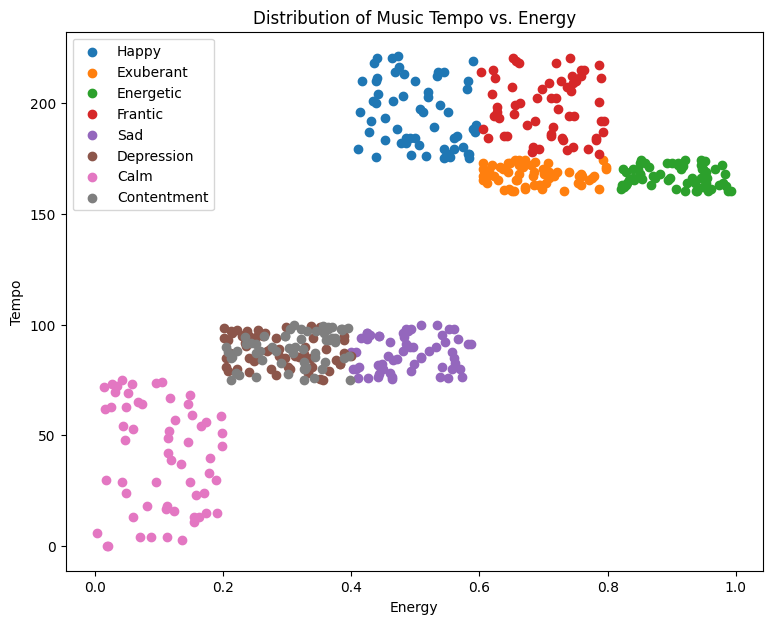

In [278]:
plt.figure(figsize=(9,7))
for mood in ideal_cases.keys():
    X = [x['energy'] for x in ideal_cases[mood]]
    Y = [x['tempo'] for x in ideal_cases[mood]]
    plt.scatter(X, Y, label=mood)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Tempo')
plt.title('Distribution of Music Tempo vs. Energy')
plt.show()

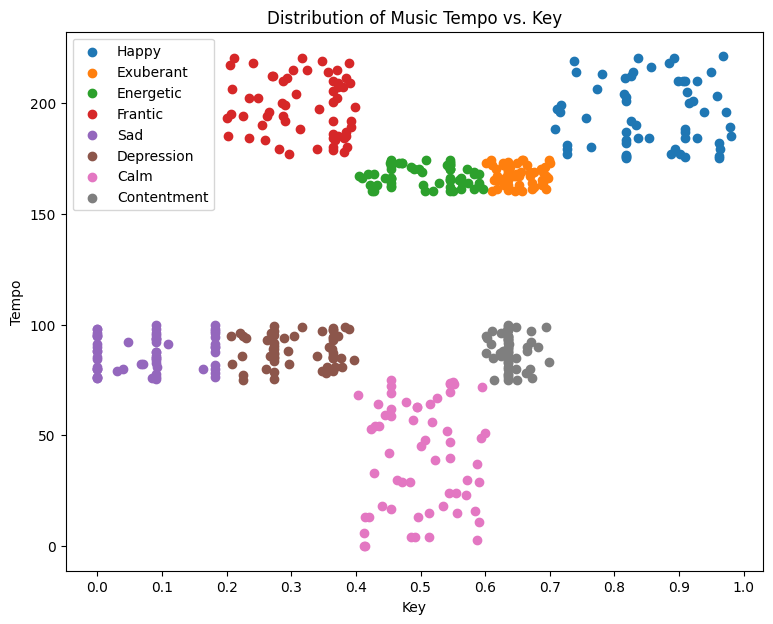

In [279]:
plt.figure(figsize=(9,7))
for mood in ideal_cases.keys():
    X = [x['key'] for x in ideal_cases[mood]]
    Y = [x['tempo'] for x in ideal_cases[mood]]
    plt.scatter(X, Y, label=mood)
plt.legend()
plt.xlabel('Key')
plt.xticks(np.arange(0, 1.1, 0.1))
plt.ylabel('Tempo')
plt.title('Distribution of Music Tempo vs. Key')
plt.show()


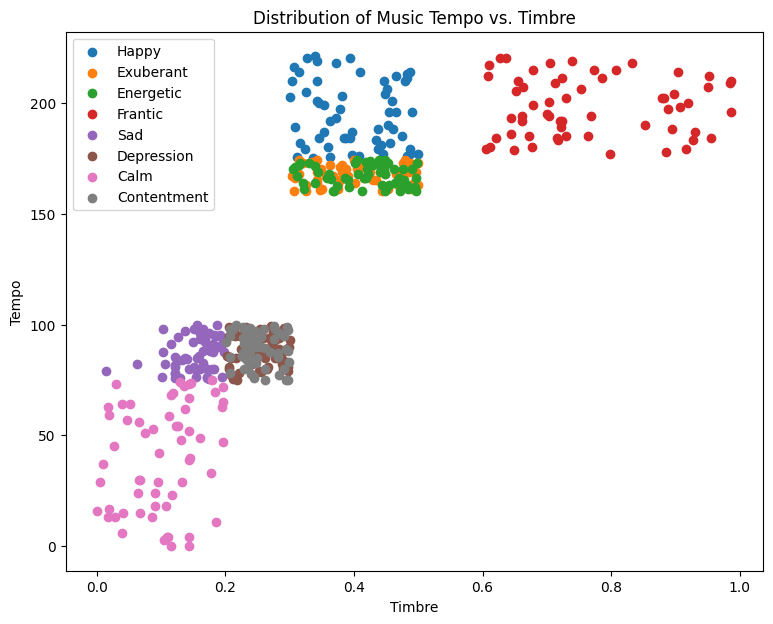

In [280]:
plt.figure(figsize=(9,7))
for mood in ideal_cases.keys():
    X = [x['timbre'] for x in ideal_cases[mood]]
    Y = [x['tempo'] for x in ideal_cases[mood]]
    plt.scatter(X, Y, label=mood)
plt.legend()
plt.xlabel('Timbre')
plt.ylabel('Tempo')
plt.title('Distribution of Music Tempo vs. Timbre')
plt.show()

In [281]:
ideal_cases_df = pd.concat([pd.DataFrame(ideal_cases[mood], columns=spotify_data.columns) for mood in ideal_cases.keys()])
ideal_cases_df['mood'] = [mood for mood in ideal_cases.keys() for _ in range(len(ideal_cases[mood]))]
ideal_cases_df = ideal_cases_df.reset_index(drop=True)

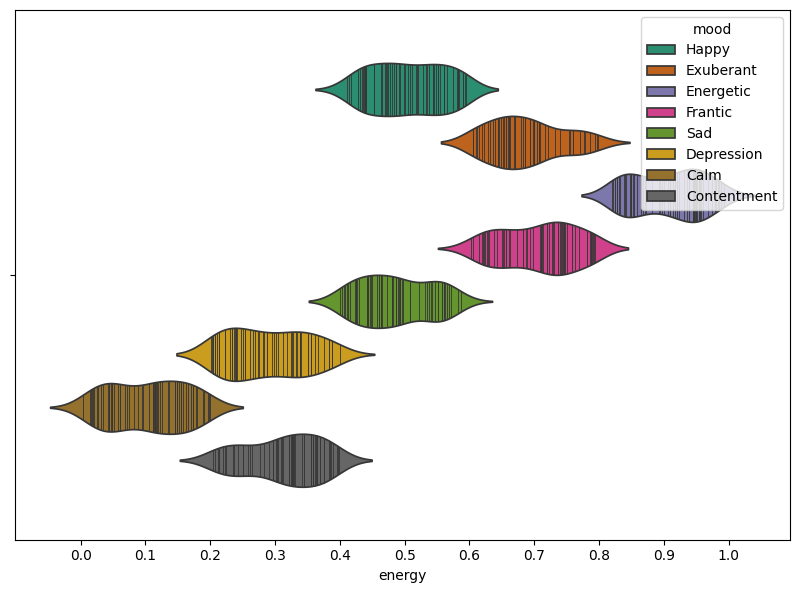

In [282]:
figsize = (10, 0.86 * len(ideal_cases_df['mood'].unique()))
plt.figure(figsize=figsize)
plt.xticks(np.arange(0, 1.1, 0.1))
sns.violinplot(ideal_cases_df, x='energy', hue='mood', inner='stick', palette='Dark2')
plt.show()

### Support Vector Classification (SVC) on Spotify Dataset

In [283]:
import warnings
warnings.filterwarnings('ignore')
svm_clf = LinearSVC(max_iter=150000, random_state=31)

# Separate features and target
X = ideal_cases_df.drop('mood', axis=1)
y = ideal_cases_df['mood']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [284]:
# Train the model
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.90625


In [285]:
# Save model to picle file
with open("music_svm_model.pkl", "wb") as f: pickle.dump(svm_clf, f)

In [286]:
tests = {
  'Happy 1'       : {'energy':0.79, 'key':0.45, 'tempo':100, 'timbre':0.30},    # Bastille - happier
  'Happy 2'       : {'energy':0.76, 'key':0.45, 'tempo':160, 'timbre':0.52},    # pharrell williams - happy
  'Sad 1'         : {'energy':0.39, 'key':0.00, 'tempo':134, 'timbre':0.24},    # xxxtentacion - jocelyn flores
  'Sad 2'         : {'energy':0.81, 'key':0.64, 'tempo':104, 'timbre':0.14},    # green day - when sept ends
  'Energetic 1'   : {'energy':0.97, 'key':0.70, 'tempo':142, 'timbre':0.33},    # marshmello - check this out
  'Energetic 2'   : {'energy':0.67, 'key':0.64, 'tempo':159, 'timbre':0.23},    # Marimba - Gangnam Style
  'Energetic 3'   : {'energy':0.87, 'key':0.73, 'tempo':130, 'timbre':0.79},    # YOASOBI - racing into the night
  'Exuberant'     : {'energy':0.96, 'key':0.50, 'tempo':160, 'timbre':0.84},    # ke$ha, pitbull - timbre
  'Contentment 1' : {'energy':0.45, 'key':0.75, 'tempo':89,  'timbre':0.81},    # UB40 - red red wine
  'Contentment 2' : {'energy':0.35, 'key':0.27, 'tempo':144, 'timbre':0.38},    # Vancouver Sleep Clinic - 405
  'Depression'    : {'energy':0.32, 'key':0.64, 'tempo':148, 'timbre':0.26}     # skylar grey - words
}

# Predict examples
for key, value in tests.items():
    predicted_mood = svm_clf.predict(pd.DataFrame([value]))
    print("Acutal Song Mood:",key,f"{(14 - len(key)) * ' '}","Predicted Mood:",predicted_mood[0])

Acutal Song Mood: Happy 1         Predicted Mood: Energetic
Acutal Song Mood: Happy 2         Predicted Mood: Energetic
Acutal Song Mood: Sad 1           Predicted Mood: Sad
Acutal Song Mood: Sad 2           Predicted Mood: Energetic
Acutal Song Mood: Energetic 1     Predicted Mood: Energetic
Acutal Song Mood: Energetic 2     Predicted Mood: Exuberant
Acutal Song Mood: Energetic 3     Predicted Mood: Energetic
Acutal Song Mood: Exuberant       Predicted Mood: Energetic
Acutal Song Mood: Contentment 1   Predicted Mood: Contentment
Acutal Song Mood: Contentment 2   Predicted Mood: Depression
Acutal Song Mood: Depression      Predicted Mood: Happy


## Google Emotions Data Pre-processing

In [3]:
df = pd.read_csv('go_emotions_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    211225 non-null  object
 1   text                  211225 non-null  object
 2   example_very_unclear  211225 non-null  bool  
 3   admiration            211225 non-null  int64 
 4   amusement             211225 non-null  int64 
 5   anger                 211225 non-null  int64 
 6   annoyance             211225 non-null  int64 
 7   approval              211225 non-null  int64 
 8   caring                211225 non-null  int64 
 9   confusion             211225 non-null  int64 
 10  curiosity             211225 non-null  int64 
 11  desire                211225 non-null  int64 
 12  disappointment        211225 non-null  int64 
 13  disapproval           211225 non-null  int64 
 14  disgust               211225 non-null  int64 
 15  embarrassment    

In [4]:
df = df[df['example_very_unclear'] == False]
df = df[df['neutral']              == False]
df = df[df['disgust']              == False]
df = df[df['desire']               == False]
df = df[df['anger']                == False]
df = df[df['annoyance']            == False]
df = df[df['confusion']            == False]
df = df[df['embarrassment']        == False]
df = df[df['approval']             == False]
df = df[df['disapproval']          == False]
df = df[df['surprise']             == False]
df = df.drop(columns=['id', 'example_very_unclear', 'neutral', 'disgust', 'desire', 'anger', 'annoyance', 'confusion', 'embarrassment', 'approval', 'disapproval', 'surprise'])
df

,text,admiration,amusement,caring,curiosity,disappointment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness
0,That game hurt.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,Right? Considering it’s such an important docu...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
7,That's crazy; I went to a super [RELIGION] hig...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,that's adorable asf,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211218,"Thanks, [NAME]",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
211219,"Well, I'm glad you're out of all that now. How...",0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
211220,Everyone likes [NAME].,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
211221,Well when you’ve imported about a gazillion of...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
# emotions_map = {
#     "calm":        ["curiosity", "realization", "relief"],
#     "energetic":   ["excitement"],
#     "frantic":     ["fear", "nervousness"],
#     "exuberant":   ["amusement", "pride"],
#     "happy":       ["joy", "love"],
#     "sad":         ["sadness"],
#     "depression":  ["grief", "remorse"],
#     "contentment": ["admiration", "caring", "gratitude"]
# }
emotions_map = {
    "calm":        ["relief"],
    "energetic":   ["excitement"],
    "frantic":     ["fear"],
    "exuberant":   ["amusement"],
    "happy":       ["joy"],
    "sad":         ["sadness"],
    "depression":  ["grief"],
    "contentment": ["gratitude"]
}

for emotion in emotions_map.keys(): df[emotion] = None

In [6]:
for index, row in df.iterrows():
    for emotion in emotions_map:
        x = emotions_map[emotion]
        df.at[index, emotion] = 1 if sum((df.at[index, x[i]]) for i in range(0, len(x))) >= 1 else 0

In [7]:
calm_count        = df[df['calm']        == 1]['calm'].sum()
energetic_count   = df[df['energetic']   == 1]['energetic'].sum()
frantic_count     = df[df['frantic']     == 1]['frantic'].sum()
exuberant_count   = df[df['exuberant']   == 1]['exuberant'].sum()
happy_count       = df[df['happy']       == 1]['happy'].sum()
sad_count         = df[df['sad']         == 1]['sad'].sum()
depression_count  = df[df['depression']  == 1]['depression'].sum()
contentment_count = df[df['contentment'] == 1]['contentment'].sum()
print('Calm:', calm_count)
print('Energetic:', energetic_count)
print('Frantic:', frantic_count)
print('Exuberant:', exuberant_count)
print('Happy:', happy_count)
print('Sad:', sad_count)
print('Depression:', depression_count)
print('Contentment:', contentment_count)

Calm: 1125
Energetic: 4958
Frantic: 2691
Exuberant: 8079
Happy: 7185
Sad: 5840
Depression: 590
Contentment: 10275


### Rationale for Column Dropping
The columns identified below were used to generate the mood cluster columns (calm, energetic, frantic, exuberant, happy, sad, depression, contentment). Due to the mood cluster columns being used for further analysis, the columns used to create it were not required, thus accounting for removal.

In [8]:
columns_to_keep = [
    'text', 'calm', 'energetic', 'frantic', 'exuberant', 'happy', 'sad',
    'depression', 'contentment'
]
columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
df = df.drop(columns=columns_to_drop)

In [9]:
columns_to_check = ['calm', 'energetic', 'frantic', 'exuberant', 'happy', 'sad', 'depression', 'contentment']
df = df[df[columns_to_check].sum(axis=1) != 0]
df = df.reset_index(drop=True)

In [10]:
df

,text,calm,energetic,frantic,exuberant,happy,sad,depression,contentment
0,That game hurt.,0,0,0,0,0,1,0,0
1,Right? Considering it’s such an important docu...,0,0,0,0,0,0,0,1
2,That's crazy; I went to a super [RELIGION] hig...,0,0,0,1,0,0,0,0
3,that's adorable asf,0,0,0,1,0,0,0,0
4,"""Sponge Blurb Pubs Quaw Haha GURR ha AAa!"" fin...",0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
37845,Oh wow My heart ✨,0,1,0,0,0,0,0,0
37846,Thanks a [NAME],0,0,0,0,0,0,0,1
37847,What a great photo and you two look so happy. 😍,0,0,0,0,1,0,0,0
37848,"Thanks, [NAME]",0,0,0,0,0,0,0,1


In [11]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_text(text: str):
    text = text.lower()
    text = re.sub(r'[^a-z\'\s]', ' ' , text)
    tokens = word_tokenize(text)
    text = [word.strip() if word not in ['religion', 'name'] else '' for word in tokens]
    text = ' '.join(text)
    text = [lemmatizer.lemmatize(word) if len(word) > 4 else word for word in text.split()]
    return ' '.join(text)

In [12]:
cleaned_df = pd.DataFrame(df)

In [13]:
cleaned_df['cleaned_text'] = cleaned_df['text'].apply(clean_text)

In [14]:
cleaned_df = cleaned_df.drop('text', axis=1)
cleaned_df = cleaned_df[['cleaned_text', 'calm', 'energetic', 'frantic' ,'exuberant', 'happy', 'sad', 'depression', 'contentment']]
cleaned_df

,cleaned_text,calm,energetic,frantic,exuberant,happy,sad,depression,contentment
0,that game hurt,0,0,0,0,0,1,0,0
1,right considering it s such an important docum...,0,0,0,0,0,0,0,1
2,that 's crazy i went to a super high school an...,0,0,0,1,0,0,0,0
3,that 's adorable asf,0,0,0,1,0,0,0,0
4,sponge blurb pubs quaw haha gurr ha aaa finale...,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
37845,oh wow my heart,0,1,0,0,0,0,0,0
37846,thanks a,0,0,0,0,0,0,0,1
37847,what a great photo and you two look so happy,0,0,0,0,1,0,0,0
37848,thanks,0,0,0,0,0,0,0,1


### Reverse One-Hot on Google Emotions Dataset

In [15]:
def determine_class(row):
    if row['calm'] == 1:       return 'calm'
    if row['energetic'] == 1:  return 'energetic'
    if row['frantic'] == 1:    return 'frantic'
    if row['exuberant'] == 1:  return 'exuberant'
    if row['happy'] == 1:      return 'happy'
    if row['sad'] == 1:        return 'sad'
    if row['depression'] == 1: return 'depression'
    return 'contentment'

In [16]:
# prompt: Ensure all rows have a class label. If not, drop the row

cleaned_df = cleaned_df[cleaned_df.apply(determine_class, axis=1).notnull()]


In [17]:
cleaned_df['class'] = None
for index, row in df.iterrows():
    cleaned_df.at[index, 'class'] = determine_class(row)

In [18]:
calm        = cleaned_df[cleaned_df['class'] == 'calm']
energetic   = cleaned_df[cleaned_df['class'] == 'energetic']
frantic     = cleaned_df[cleaned_df['class'] == 'frantic']
exuberant   = cleaned_df[cleaned_df['class'] == 'exuberant']
happy       = cleaned_df[cleaned_df['class'] == 'happy']
sad         = cleaned_df[cleaned_df['class'] == 'sad']
depression  = cleaned_df[cleaned_df['class'] == 'depression']
contentment = cleaned_df[cleaned_df['class'] == 'contentment']

In [19]:
cleaned_df = shuffle(cleaned_df)

In [20]:
calm = calm.head(depression.shape[0])
energetic = energetic.head(depression.shape[0])
frantic = frantic.head(depression.shape[0])
exuberant = exuberant.head(depression.shape[0])
happy = happy.head(depression.shape[0])
sad = sad.head(depression.shape[0])
contentment = contentment.head(depression.shape[0])

balanced_df = pd.concat([calm,energetic,frantic,exuberant,happy,sad,contentment,depression])
balanced_df = shuffle(balanced_df)
# X, y = balanced_df['cleaned_text'], balanced_df['class']
X, y = cleaned_df['cleaned_text'], cleaned_df['class']

## Emotion Detection

1. Logistic Regression Model + TFIDF
2. Recurrent Neural Network (RNN) using Long-Short Term Memory (LSTM)



### 1. Logit Model + TFIDF

In [21]:
tfidf = TfidfVectorizer(stop_words='english')
logit = LogisticRegression(multi_class='multinomial', solver='newton-cg', max_iter=25000, random_state=937, n_jobs=8)

def text_fit(X, y, model, clf_model):
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'Model f1: {f1}')
    print(f"Accuracy: {accuracy}")
    print(f"Recall: {recall}")
    print(f"Precision: {precision}")

text_fit(X, y, tfidf, logit)

# features: 14590
# train records: 28387
# test records: 9463
Model f1: 0.5430631092463233
Accuracy: 0.6745218218323998
Recall: 0.5292957111639394
Precision: 0.626557143829952


### 2. Recurrent Neural Network using Long-Short Term Memory (LSTM)

In [124]:
EMBEDDING_DIM = 128  # Dimensionality of word embeddings

# Load and preprocess text data (replace with your data loading)
text_data = cleaned_df['cleaned_text'].values
emotion_labels = cleaned_df[emotions_map.keys()].values

# Tokenization (replace with actual tokenization logic)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
sequences = tokenizer.texts_to_sequences(text_data)

# Pad sequences
maxlen = np.max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=maxlen)

# Find vocab size
vocab_size = len(tokenizer.word_index) + 1

In [125]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, emotion_labels, test_size=0.2, random_state=42)

# Force type as float32 for Numpy-Tensor conversion
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [202]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(8, activation='softmax'))

In [219]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[Precision()])

# Train the model (replace with actual training data)
model.fit(X_train, y_train, epochs=12, batch_size=32, validation_split=0.2)

Epoch 1/12
757/757 [==============================] - 60s 74ms/step - loss: 0.6290 - precision_7: 0.8911 - val_loss: 2.1474 - val_precision_7: 0.6919
Epoch 2/12
757/757 [==============================] - 53s 69ms/step - loss: 0.6191 - precision_7: 0.8940 - val_loss: 2.3212 - val_precision_7: 0.6898
Epoch 3/12
757/757 [==============================] - 52s 68ms/step - loss: 0.6137 - precision_7: 0.8959 - val_loss: 2.2052 - val_precision_7: 0.6865
Epoch 4/12
757/757 [==============================] - 54s 71ms/step - loss: 0.6116 - precision_7: 0.8962 - val_loss: 2.4717 - val_precision_7: 0.6783
Epoch 5/12
757/757 [==============================] - 54s 72ms/step - loss: 0.6265 - precision_7: 0.8939 - val_loss: 2.4937 - val_precision_7: 0.6863
Epoch 6/12
757/757 [==============================] - 54s 71ms/step - loss: 0.6155 - precision_7: 0.8969 - val_loss: 2.1526 - val_precision_7: 0.6795
Epoch 7/12
757/757 [==============================] - 52s 69ms/step - loss: 0.6171 - precision_7: 0.

In [220]:
loss, precision = model.evaluate(X_test, y_test)
print(f'Training Loss: {loss}, Training  Precision: {precision}')

237/237 [==============================] - 4s 17ms/step - loss: 3.0560 - precision_7: 0.6675
Training Loss: 3.056041717529297, Training  Precision: 0.6674500703811646


In [236]:
model.save("emotion_classification_model_epoch12_precision.keras")

In [222]:
def label_to_emotion(label: int) -> str:
    return list(emotions_map.keys())[label]

In [255]:
# Evaluate the model (replace with actual test data)
test_data = ["late night relaxation"]
test_seq = tokenizer.texts_to_sequences(test_data)
test_padded_seq = pad_sequences(test_seq, maxlen=maxlen)
prediction = model.predict(test_padded_seq)

print('Input:', test_data)
print("Predicted emotion:", label_to_emotion(np.argmax(prediction[0])))

1/1 [==============================] - 0s 43ms/step
Input: ['late night relaxation']
Predicted emotion: exuberant
